<a href="https://colab.research.google.com/github/hyxxnii/Dacon/blob/master/%EC%A0%9C%EC%A3%BC%20%EB%B2%84%EC%8A%A4%20%EC%9A%B4%ED%96%89%EC%8B%9C%EA%B0%84%20%EC%98%88%EC%B8%A1/%EB%B2%84%EC%8A%A4%20%EC%9A%B4%ED%96%89%EC%8B%9C%EA%B0%84%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## 버스 운행시간 예측 경진대회
- 회귀 | RMSE
- 해당 날짜 별, 노선 및 버스 ID가 주어진 상황에서 현재 정류소의 이름과 현재 정류장 도착 시간을 이용하여, 다음 정류장에 도착할 때까지 걸리는 시간을 예측
   
**데이터 설명**
- id : 고유 id
- date : 버스 운행 날짜
- route_id : 버스 노선 ID
- vh_id : 버스 id
- route_nm : 버스 노선 실제 번호
- now_latitude : 현재 정류소의 위도
- now_longitude : 현재 정류소의 경도
- now_station : 현재 정류소 이름
- now_arrive_time : 현재 정류장에 도착한 시간
- distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
- next_station : 다음 정류소 이름
- next_latitude : 다음 정류소의 위도
- next_longitude : 다음 정류소의 경도
- next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

# 1. Library & Data

In [3]:
## matplotlib 사용시 한국어 나오게 하는 코드
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

plt.style.use("fivethirtyeight")
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [67]:
train_df = pd.read_csv('./gdrive/My Drive/data/bus_train.csv')
test_df = pd.read_csv('./gdrive/My Drive/data/bus_test.csv')

train_len = len(train_df)
dataset = pd.concat([train_df, test_df]).reset_index(drop=True)

In [9]:
display(train_df.head())
display(test_df.head())
# train_df의 data는 10/15일부터, test_df의 data는 10/29일부터 

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355


# 2. Exploratory Data Analysis (EDA)

In [63]:
print('Size of train data : ', train_df.shape)
print('Size of test data : ', test_df.shape)

Size of train data :  (210457, 14)
Size of test data :  (91774, 13)


In [74]:
display(train_df.isnull().sum())
print('\n')
display(test_df.isnull().sum())
# null 값 없음

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

In [12]:
display(train_df.info())
print('\n\n')
display(test_df.info())

# now_arrive_time 변수 -> '시'를 빼고 int형 변환
# date 변수 -> datetime() 변환
# now_station, next_station, route_nm -> 수치형 변환,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


None




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  object 
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  object 
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 9.1+ MB


None

In [13]:
display(train_df['date'].agg(['min', 'max']))
print('\n\n')
display(test_df['date'].agg(['min', 'max']))

min    2019-10-15
max    2019-10-28
Name: date, dtype: object

min    2019-10-29
max    2019-11-05
Name: date, dtype: object

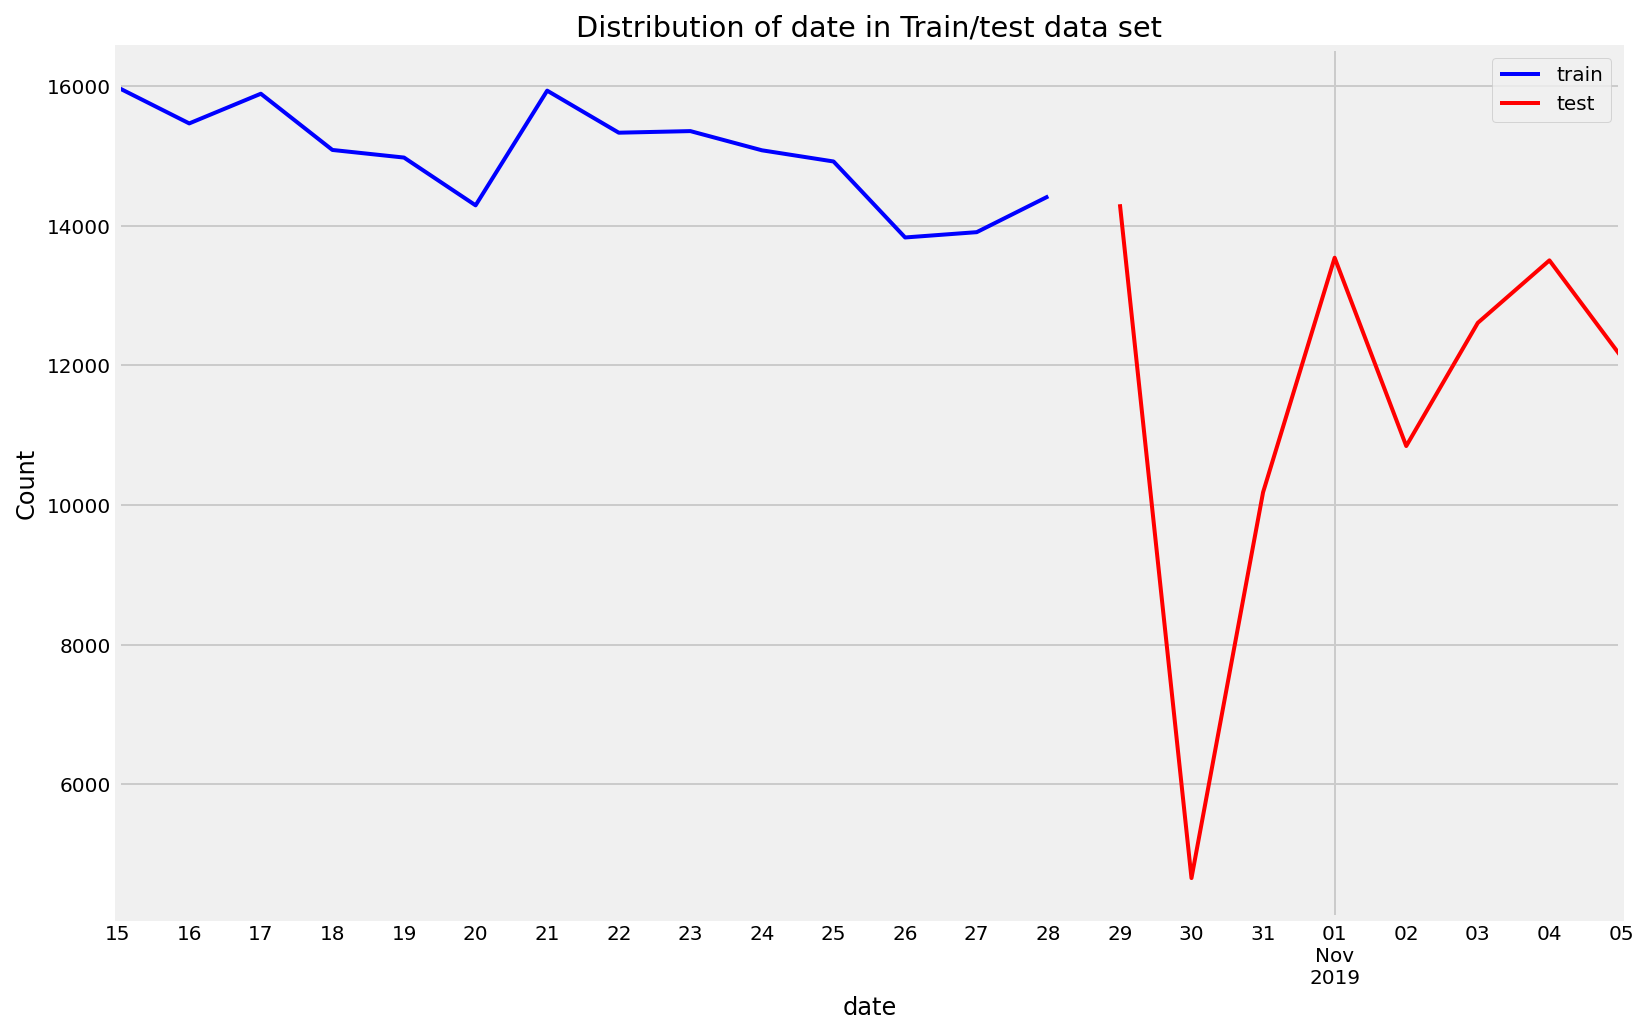

In [21]:
# 'date' => datetime 형식 변환
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%d', errors='raise')
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d', errors='raise')

# 'date' 분포
plt.figure(figsize=(12,8))
train_df['date'].value_counts().sort_index().plot(color='b', lw=2, label='train') 
test_df['date'].value_counts().sort_index().plot(color='r', lw=2, label='test')
plt.legend()
plt.xlabel('date')
plt.ylabel('Count')
plt.title('Distribution of date in Train/test data set')
plt.show()


# 딱히 일자 별 패턴이 있어보이진 않음
# train과 test data의 'date' 패턴이 비슷하지않음 
#

In [25]:
print(len(set(train_df['route_id'])))
print(len(set(test_df['route_id'])))

21
21


In [26]:
print(len(set(train_df['vh_id'])))
print(len(set(test_df['vh_id'])))

104
100


In [28]:
train_vh_id_set = set(train_df['vh_id'])
test_vh_id_set = set(test_df['vh_id'])

# train과 test에 공통으로 포함되어 있는 vh_id
common_vh_id = train_vh_id_set.intersection(test_vh_id_set)
print('공통으로 포함되어 있는 vh_id 수: ',common_vh_id)

# train에만 있는 vh_id
only_train_vh_id = train_vh_id_set.difference(test_vh_id_set)
print('train에만 있는 vh_id 수: {0}, vh_id: {1}'.format(len(only_train_vh_id), only_train_vh_id))

# test에만 있는 vh_id
only_test_vh_id = test_vh_id_set.difference(train_vh_id_set)
print('test에만 있는 vh_id 수: {0}, vh_id: {1}'.format(len(only_test_vh_id), only_test_vh_id))

공통으로 포함되어 있는 vh_id 수:  {7997001, 7997002, 7997004, 7997022, 7983200, 7997025, 7983201, 7983202, 7997028, 7997031, 7997032, 7997033, 7997034, 7997035, 7997040, 7997041, 7997043, 7997044, 7983222, 7983224, 7983225, 7983226, 7983227, 7983228, 7983229, 7997056, 7997058, 7997062, 7997064, 7997067, 7997070, 7997080, 7997082, 7997085, 7997086, 7997087, 7997089, 7997090, 7997095, 7997107, 7997110, 7997111, 7997112, 7997115, 7997118, 7997119, 7997120, 7997123, 7997124, 7983400, 7983401, 7983402, 7983403, 7983406, 7983409, 7983412, 7983414, 7983415, 7983416, 7983417, 7983420, 7983430, 7983431, 7983432, 7983439, 7983441, 7983444, 7983445, 7983481, 7983482, 7983483, 7983484, 7983485, 7983486, 7983005, 7983010, 7983013, 7983014, 7983019, 7983026, 7983028, 7983031, 7983032, 7983036, 7983038, 7983041, 7983063, 7983065, 7983066, 7983067, 7983073, 7983074, 7983075, 7983091, 7983092, 7983093, 7983094, 7983095, 7983096, 7983097}
train에만 있는 vh_id 수: 4, vh_id: {7983000, 7983051, 7983045, 7997077}
test에만 있는

In [62]:
train_df[['distance', 'next_arrive_time']].groupby('distance').mean().sort_values(by='next_arrive_time')

,next_arrive_time
distance,
97.0,17.657143
171.0,17.774869
208.0,22.535211
134.0,22.868327
175.0,23.045872
...,...
4429.0,309.953488
518.0,333.735805
1859.0,360.272393


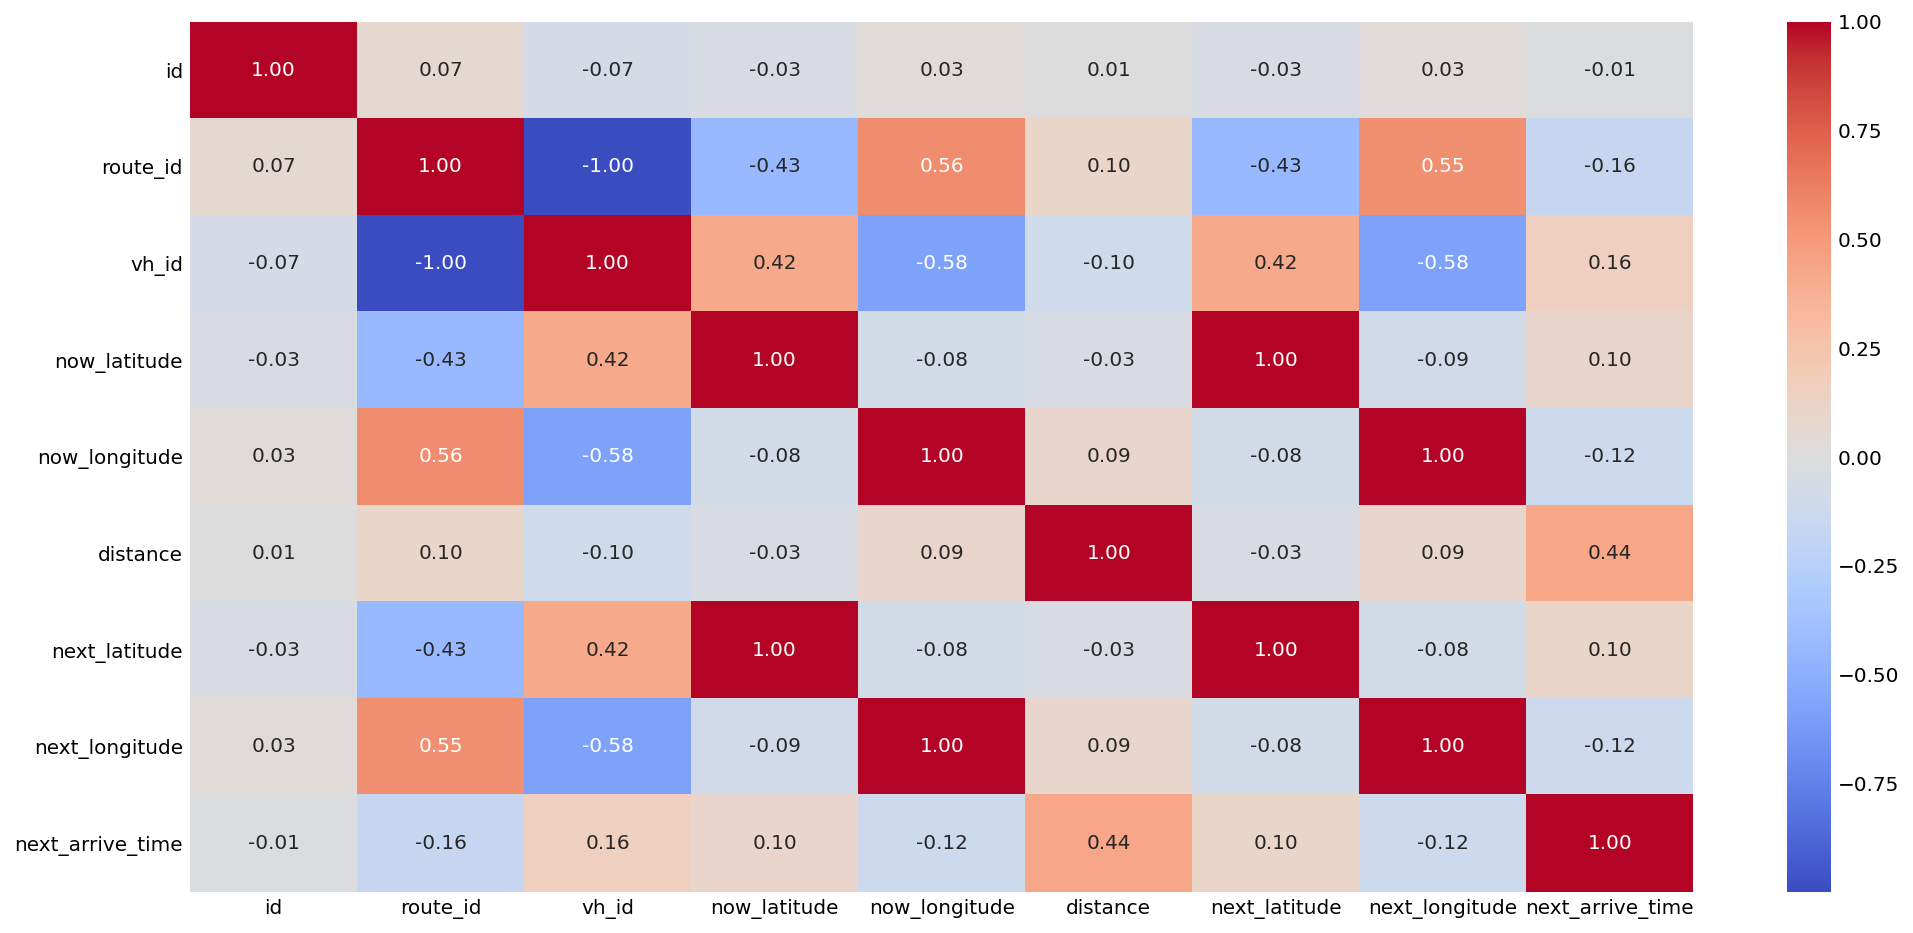

In [61]:
# Numeric feature의 상관관계
col = ['id', 'route_id', 'vh_id', 'now_latitude', 'now_longitude', 'distance', 'next_latitude', 'next_longitude', 'next_arrive_time']
plt.figure(figsize=(15,8))
sns.heatmap(train_df[col].corr(), annot=True, fmt='.2f', cmap='coolwarm')

# target 변수인 'next_arrive_time'과 가장 상관관계가 있는 변수는 'distance'
# feature들 간 다중공선성은 없어 보임
# 위도, 경도 별로 지도에 찍어서 봐야겠음
# 위도, 경도를 이용하여 거리도 구해보자 

In [ ]:
# Categorical feature의 상관관계


In [33]:
target = train_df['next_arrive_time']
target.value_counts().sort_index()

6         7
8        36
10       71
12      164
14      397
       ... 
2888      1
2906      2
2930      1
2966      1
2996      1
Name: next_arrive_time, Length: 596, dtype: int64

Text(0, 0.5, 'count')

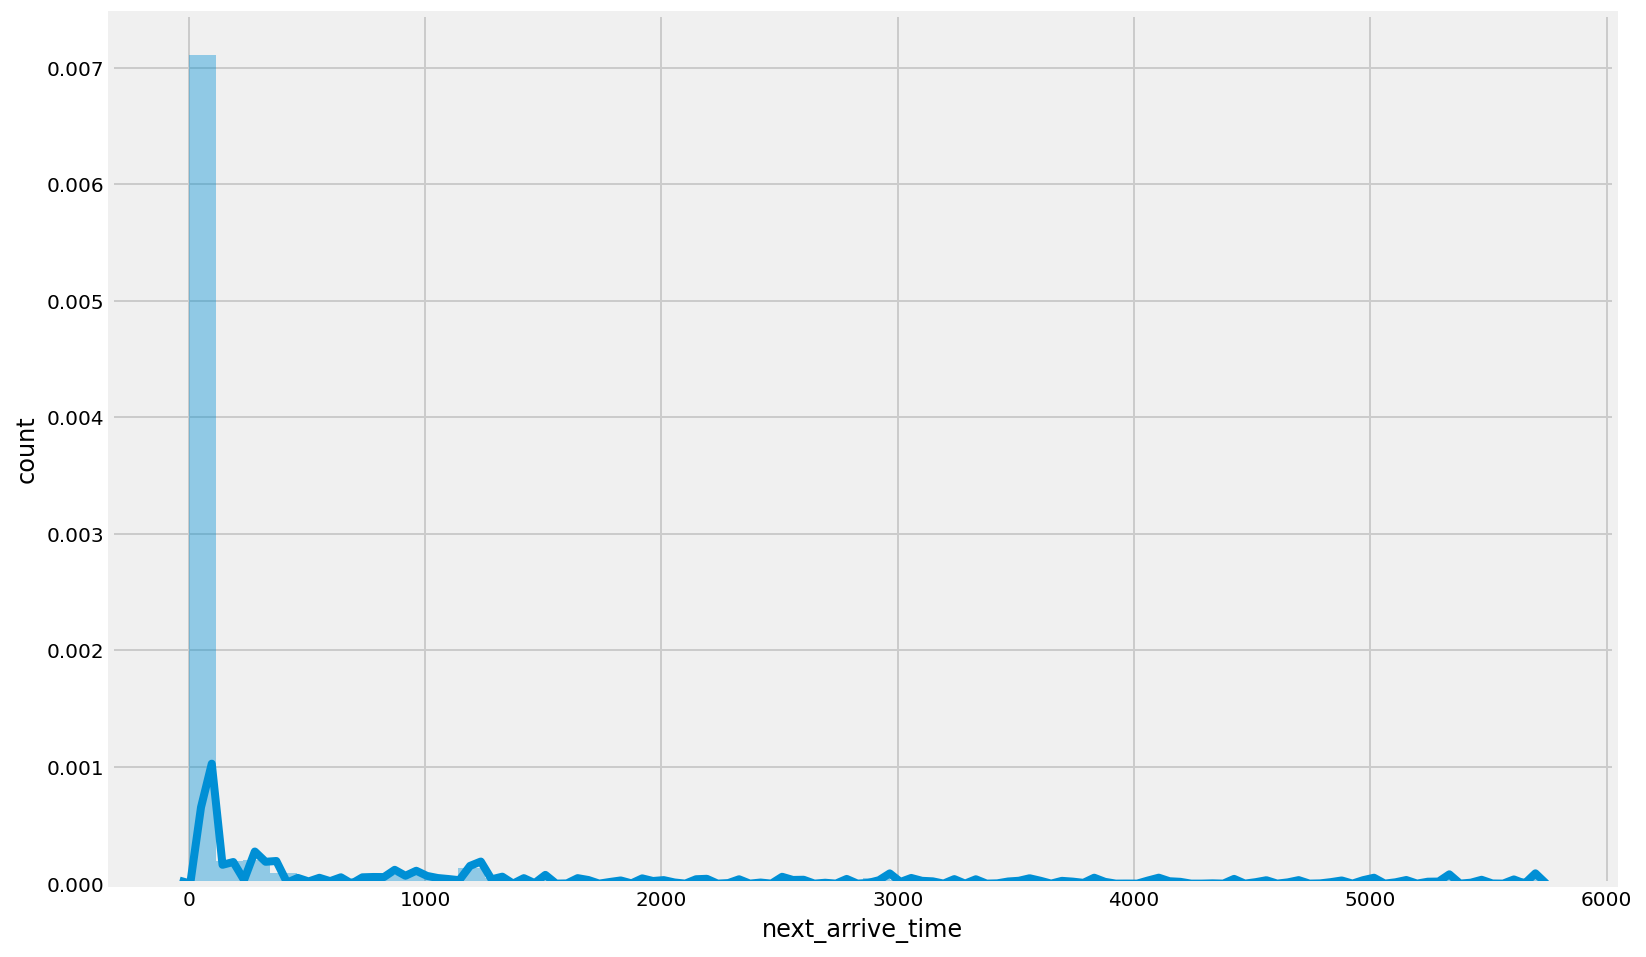

In [36]:
# Target 분포

plt.figure(figsize=(12, 8))
sns.distplot(target.value_counts().sort_index())
plt.xlabel('next_arrive_time')
plt.ylabel('count')

# 정규분포 변환 필요 (np.log1p() or np.log() or np.sqrt())

In [40]:
len(train_df[train_df['next_arrive_time']==0])

0

# 3. Data Cleansing & Pre-Processing

# 4. Feature Engineering & Initial Modeling

# 5. Model Tuning & Evaluation

# 6. Conclusion & Discussion